In [2]:
# =============================================================================
# obj 파일을 단순화 하고 label을 재배열
# =============================================================================
import open3d as o3d
import numpy as np
from scipy.spatial import cKDTree
import os

# 경로 설정
mesh_dir = r"C:\Users\konyang\Desktop\MeshCNN_TF\data\dataset\mesh"
label_dir = r"C:\Users\konyang\Desktop\MeshCNN_TF\data\dataset\lebel"
save_mesh_dir = r"C:\Users\konyang\Desktop\MeshCNN_TF\data\dataset\simplified_mesh"
save_label_dir = r"C:\Users\konyang\Desktop\MeshCNN_TF\data\dataset\simplified_label"

# 저장 경로 폴더 생성
os.makedirs(save_mesh_dir, exist_ok=True)
os.makedirs(save_label_dir, exist_ok=True)

# 메쉬 파일 목록 가져오기
mesh_files = [f for f in os.listdir(mesh_dir) if f.endswith('.obj')]

# 처리 루프
for mesh_file in mesh_files:
    mesh_path = os.path.join(mesh_dir, mesh_file)
    label_file = mesh_file.replace('.obj', '_label.npy')
    label_path = os.path.join(label_dir, label_file)

    # 존재 확인
    if not os.path.exists(label_path):
        print(f"⚠️ 라벨 파일 누락: {label_file}, 스킵합니다.")
        continue

    print(f"🔄 처리 중: {mesh_file}")

    # 메쉬 및 라벨 로딩
    mesh_o3d = o3d.io.read_triangle_mesh(mesh_path)
    mesh_o3d.compute_vertex_normals()
    labels = np.load(label_path)

    # 메쉬 단순화
    target_face_count = 10000
    simplified_o3d = mesh_o3d.simplify_quadric_decimation(target_number_of_triangles=target_face_count)

    # 중심점 계산
    original_faces = np.asarray(mesh_o3d.triangles)
    original_vertices = np.asarray(mesh_o3d.vertices)
    original_centroids = original_vertices[original_faces].mean(axis=1)

    simplified_faces = np.asarray(simplified_o3d.triangles)
    simplified_vertices = np.asarray(simplified_o3d.vertices)
    simplified_centroids = simplified_vertices[simplified_faces].mean(axis=1)

    # KDTree로 최근접 원본 면 추정
    tree = cKDTree(original_centroids)
    _, idx = tree.query(simplified_centroids)

    # 라벨 매핑
    simplified_labels = labels[idx]

    # 저장
    mesh_save_path = os.path.join(save_mesh_dir, mesh_file)
    label_save_path = os.path.join(save_label_dir, label_file)

    o3d.io.write_triangle_mesh(mesh_save_path, simplified_o3d)
    np.save(label_save_path, simplified_labels)

    print(f"✅ 저장 완료: {mesh_file} → {mesh_save_path}")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
🔄 처리 중: A0083_abnormal.obj
[Open3D WARNING] Write OBJ can not include triangle normals.
✅ 저장 완료: A0083_abnormal.obj → C:\Users\konyang\Desktop\MeshCNN_TF\data\dataset\simplified_mesh\A0083_abnormal.obj
🔄 처리 중: A0083_normal.obj
[Open3D WARNING] Write OBJ can not include triangle normals.
✅ 저장 완료: A0083_normal.obj → C:\Users\konyang\Desktop\MeshCNN_TF\data\dataset\simplified_mesh\A0083_normal.obj
🔄 처리 중: A0087_abnormal.obj
[Open3D WARNING] Write OBJ can not include triangle normals.
✅ 저장 완료: A0087_abnormal.obj → C:\Users\konyang\Desktop\MeshCNN_TF\data\dataset\simplified_mesh\A0087_abnormal.obj
🔄 처리 중: A0087_normal.obj
[Open3D WARNING] Write OBJ can not include triangle normals.
✅ 저장 완료: A0087_normal.obj → C:\Users\konyang\Desktop\MeshCNN_TF\data\dataset\simplified_mesh\A0087_normal.obj
🔄 처리 중: A0103_abnormal.obj
[Open3D 

In [4]:
# =============================================================================
# 단순화된 obj 파일의 정점과 면 수를 csv 파일로 저장
# =============================================================================
import pandas as pd

# 단순화된 메쉬 저장 폴더
save_mesh_dir = r"C:\Users\konyang\Desktop\MeshCNN_TF\data\dataset\simplified_mesh"

# .obj 파일 목록 가져오기
mesh_files = [f for f in os.listdir(save_mesh_dir) if f.endswith('.obj')]

# 결과 저장용 리스트
mesh_data = []

# 각 파일의 정점/면 수 수집
for mesh_file in mesh_files:
    mesh_path = os.path.join(save_mesh_dir, mesh_file)
    mesh = o3d.io.read_triangle_mesh(mesh_path)

    num_vertices = len(mesh.vertices)
    num_faces = len(mesh.triangles)

    mesh_data.append({
        "File Name": mesh_file,
        "Vertices": num_vertices,
        "Faces": num_faces
    })

# 데이터프레임으로 변환
df = pd.DataFrame(mesh_data)

# 보기 좋게 정렬 및 출력
df = df.sort_values(by="File Name").reset_index(drop=True)
df.to_csv("summary.csv", index=False)

              File Name  Vertices  Faces
0    A0083_abnormal.obj      3676   9999
1      A0083_normal.obj      3664   9999
2    A0087_abnormal.obj      3709  10000
3      A0087_normal.obj      3703  10000
4    A0103_abnormal.obj      4564  13010
..                  ...       ...    ...
345     Z078_normal.obj      3965  11774
346   Z079_abnormal.obj      4296  12846
347     Z079_normal.obj      4296  12846
348   Z080_abnormal.obj      4500  13653
349     Z080_normal.obj      4500  13653

[350 rows x 3 columns]


In [7]:
# =============================================================================
# 데이터의 결측치 확인
# =============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 요약 CSV 파일 경로
csv_path = r"C:\Users\konyang\Desktop/MeshCNN_TF/prepro/summary.csv"

# 데이터 로딩
df = pd.read_csv(csv_path)
df.head()

# 결측치 개수 출력
missing = df.isnull().sum()
print("📌 결측치 확인:")
print(missing)

# 결측이 있는 행 추출
df_missing = df[df.isnull().any(axis=1)]
print(f"\n총 {len(df_missing)}개의 행에 결측치가 있습니다.")





📌 결측치 확인:
File Name    0
Vertices     0
Faces        0
dtype: int64

총 0개의 행에 결측치가 있습니다.


총 31개의 행에서 이상치가 발견되었습니다.
              File Name  Vertices  Faces  Outlier_Vertices  Outlier_Faces  \
32   A0187_abnormal.obj      5752  17720             False           True   
33     A0187_normal.obj      5819  17894             False           True   
38   A0193_abnormal.obj      7597  22196              True           True   
39     A0193_normal.obj      7514  21918              True           True   
68   A0223_abnormal.obj      6081  18718             False           True   
69     A0223_normal.obj      6053  18599             False           True   
72   A0227_abnormal.obj      6162  18402             False           True   
73     A0227_normal.obj      6183  18452             False           True   
80   A0233_abnormal.obj      7687  23362              True           True   
81     A0233_normal.obj      7644  23295              True           True   
100  A0260_abnormal.obj      6266  18882             False           True   
102  A0262_abnormal.obj     13735  45744           

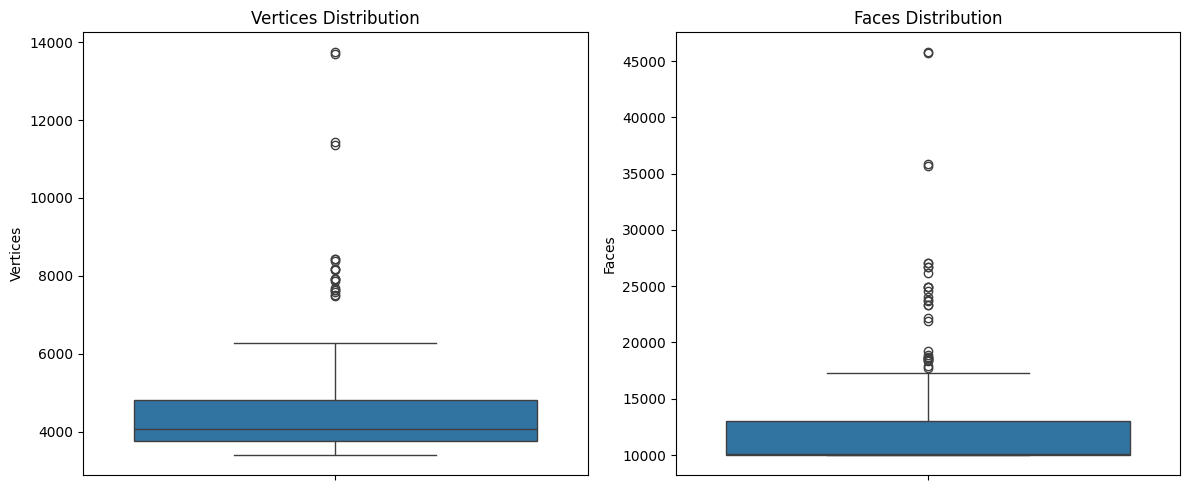

In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import open3d as o3d
import matplotlib.cm as cm

# 경로 설정
mesh_dir = r"C:\Users\konyang\Desktop\MeshCNN_TF\data\dataset\simplified_mesh"
label_dir = r"C:\Users\konyang\Desktop\MeshCNN_TF\data\dataset\simplified_label"
summary_csv = r"C:\Users\konyang\Desktop\MeshCNN_TF\prepro\summary.csv"

# 데이터 로딩
df = pd.read_csv(summary_csv)

# 이상치 탐지 함수
def detect_outliers_iqr(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return (series < lower) | (series > upper)

# 이상치 플래그 추가
df["Outlier_Vertices"] = detect_outliers_iqr(df["Vertices"])
df["Outlier_Faces"] = detect_outliers_iqr(df["Faces"])
df["Outlier"] = df["Outlier_Vertices"] | df["Outlier_Faces"]

# 이상치만 추출
df_outliers = df[df["Outlier"]]
print(f"총 {len(df_outliers)}개의 행에서 이상치가 발견되었습니다.")
print(df_outliers.head(len(df_outliers)))  # 일부 미리보기

# 이상치 시각화 (Boxplot)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=df["Vertices"])
plt.title("Vertices Distribution")

plt.subplot(1, 2, 2)
sns.boxplot(y=df["Faces"])
plt.title("Faces Distribution")

plt.tight_layout()
plt.show()

In [20]:
# 메쉬 + 라벨 시각화 함수
def visualize_mesh_with_labels(mesh, labels, title="Labeled Mesh"):
    norm_labels = (labels - labels.min()) / (labels.max() - labels.min())
    colors = cm.get_cmap('viridis')(norm_labels)[:, :3]

    face_colors = colors
    vertex_colors = np.zeros((len(mesh.vertices), 3))
    count = np.zeros(len(mesh.vertices))

    faces = np.asarray(mesh.triangles)
    for i, tri in enumerate(faces):
        for v in tri:
            vertex_colors[v] += face_colors[i]
            count[v] += 1

    count[count == 0] = 1
    vertex_colors /= count[:, None]

    mesh.vertex_colors = o3d.utility.Vector3dVector(vertex_colors)
    o3d.visualization.draw_geometries([mesh], window_name=title)

# 이상치 메쉬 시각화
for filename in df_outliers["File Name"]:
    mesh_path = os.path.join(mesh_dir, filename)
    label_path = os.path.join(label_dir, filename.replace(".obj", "_label.npy"))

    if not os.path.exists(mesh_path) or not os.path.exists(label_path):
        print(f"❌ 파일 누락: {filename}")
        continue

    mesh = o3d.io.read_triangle_mesh(mesh_path)
    labels = np.load(label_path)

    print(f"🔍 시각화: {filename}")
    visualize_mesh_with_labels(mesh, labels, title=filename)

🔍 시각화: A0187_abnormal.obj


C:\Users\konyang\AppData\Local\Temp\ipykernel_12680\976964041.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('viridis')(norm_labels)[:, :3]


🔍 시각화: A0187_normal.obj


C:\Users\konyang\AppData\Local\Temp\ipykernel_12680\976964041.py:3: RuntimeWarning: invalid value encountered in divide
  norm_labels = (labels - labels.min()) / (labels.max() - labels.min())


KeyboardInterrupt: 

In [18]:
import numpy as np

label_path = r"C:\Users\konyang\Desktop\MeshCNN_TF\data\dataset\simplified_label\A0087_abnormal_label.npy"
labels = np.load(label_path)

print(f"총 라벨 수: {len(labels)}")
print(f"라벨 데이터 타입: {labels.dtype}")

unique, counts = np.unique(labels, return_counts=True)
for val, count in zip(unique, counts):
    print(f"라벨 값 {val}: {count}개")

print("최소값:", labels.min())
print("최대값:", labels.max())
print("평균:", labels.mean())
print("0이 아닌 라벨 개수:", np.sum(labels > 0))


import trimesh

mesh_path = r"C:\Users\konyang\Desktop\MeshCNN_TF\data\dataset\simplified_mesh\A0087_abnormal.obj"
mesh = trimesh.load(mesh_path)

if len(labels) != len(mesh.faces):
    print(f"❌ 경고: 라벨 수({len(labels)}) ≠ 메쉬 면 수({len(mesh.faces)})")
else:
    print("✅ 라벨 수와 메쉬 면 수 일치")


⚠️ A0087_abnormal: 라벨에 '1' 없음 → 잘못된 데이터
⚠️ A0103_abnormal: 라벨에 '1' 없음 → 잘못된 데이터
⚠️ A0126_abnormal: 라벨에 '1' 없음 → 잘못된 데이터
⚠️ A0195_abnormal: 라벨에 '1' 없음 → 잘못된 데이터
⚠️ A0198_abnormal: 라벨에 '1' 없음 → 잘못된 데이터
⚠️ A0208_abnormal: 라벨에 '1' 없음 → 잘못된 데이터
⚠️ A0214_abnormal: 라벨에 '1' 없음 → 잘못된 데이터
⚠️ A0248_abnormal: 라벨에 '1' 없음 → 잘못된 데이터
⚠️ A0253_abnormal: 라벨에 '1' 없음 → 잘못된 데이터
⚠️ F002_abnormal: 라벨에 '1' 없음 → 잘못된 데이터
⚠️ F004_abnormal: 라벨에 '1' 없음 → 잘못된 데이터
⚠️ F005_abnormal: 라벨에 '1' 없음 → 잘못된 데이터
⚠️ F006_abnormal: 라벨에 '1' 없음 → 잘못된 데이터
⚠️ F010_abnormal: 라벨에 '1' 없음 → 잘못된 데이터
⚠️ F014_abnormal: 라벨에 '1' 없음 → 잘못된 데이터
⚠️ F015_abnormal: 라벨에 '1' 없음 → 잘못된 데이터
⚠️ F016_abnormal: 라벨에 '1' 없음 → 잘못된 데이터
⚠️ F018_abnormal: 라벨에 '1' 없음 → 잘못된 데이터
⚠️ F020_abnormal: 라벨에 '1' 없음 → 잘못된 데이터
⚠️ F021_abnormal: 라벨에 '1' 없음 → 잘못된 데이터
⚠️ F022_abnormal: 라벨에 '1' 없음 → 잘못된 데이터
⚠️ F023_abnormal: 라벨에 '1' 없음 → 잘못된 데이터
⚠️ F024_abnormal: 라벨에 '1' 없음 → 잘못된 데이터
⚠️ F025_abnormal: 라벨에 '1' 없음 → 잘못된 데이터
⚠️ F027_abnormal: 라벨에 '1' 없음 → 잘못된 데이터
⚠️ F028_abnormal

KeyboardInterrupt: 

In [25]:
import os
import numpy as np
import openpyxl

# 검사할 ID 목록
bad_ids = [
    "A0087_abnormal", "A0103_abnormal", "A0126_abnormal", "A0195_abnormal", "A0198_abnormal",
    "A0208_abnormal", "A0214_abnormal", "A0248_abnormal", "A0253_abnormal", "F002_abnormal",
    "F004_abnormal", "F005_abnormal", "F006_abnormal", "F010_abnormal", "F014_abnormal",
    "F015_abnormal", "F016_abnormal", "F018_abnormal", "F020_abnormal", "F021_abnormal",
    "F022_abnormal", "F023_abnormal", "F024_abnormal", "F025_abnormal", "F027_abnormal",
    "F028_abnormal", "F032_abnormal", "F037_abnormal", "F038_abnormal", "F040_abnormal",
    "F041_abnormal", "F043_abnormal", "F045_abnormal", "F046_abnormal", "Z001_abnormal",
    "Z002_abnormal", "Z003_abnormal", "Z006_abnormal", "Z010_abnormal", "Z011_abnormal",
    "Z012_abnormal", "Z014_abnormal", "Z015_abnormal", "Z017_abnormal", "Z019_abnormal",
    "Z021_abnormal", "Z023_abnormal", "Z024_abnormal", "Z027_abnormal", "Z028_abnormal",
    "Z029_abnormal", "Z030_abnormal", "Z035_abnormal", "Z036_abnormal", "Z038_abnormal",
    "Z039_abnormal", "Z044_abnormal", "Z049_abnormal", "Z055_abnormal", "Z057_abnormal",
    "Z069_abnormal", "Z070_abnormal", "Z073_abnormal", "Z074_abnormal", "Z075_abnormal",
    "Z076_abnormal", "Z078_abnormal", "Z080_abnormal"
]

# 원본 라벨 폴더
original_label_dir = r"C:\Users\konyang\Desktop\MeshCNN_TF\data\dataset\lebel"

# 검사 결과 저장
results = []

for case_id in bad_ids:
    label_path = os.path.join(original_label_dir, f"{case_id}_label.npy")
    
    if not os.path.exists(label_path):
        print(f"❌ 파일 없음: {case_id}")
        results.append((case_id, "MISSING"))
        continue

    labels = np.load(label_path)
    has_label = np.sum(labels == 1) > 0
    label_count = np.sum(labels == 1)

    if has_label:
        print(f"✅ {case_id}: 결절 {label_count}개 존재")
        results.append((case_id, f"OK ({label_count}개)"))
    else:
        print(f"⚠️ {case_id}: 결절 없음 (원본에도 없음)")
        results.append((case_id, "NO_LABEL_IN_ORIGINAL"))

df = pd.DataFrame(results, columns=["ID", "검사 결과"])

# 저장 경로 설정
save_path = r"C:\Users\konyang\Desktop\결절_검사_결과.xlsx"

# Excel로 저장
df.to_excel(save_path, index=False, engine='openpyxl')

print(f"\n📁 저장 완료: {save_path}")



✅ A0087_abnormal: 결절 79개 존재
✅ A0103_abnormal: 결절 16개 존재
✅ A0126_abnormal: 결절 36개 존재
✅ A0195_abnormal: 결절 242개 존재
✅ A0198_abnormal: 결절 276개 존재
✅ A0208_abnormal: 결절 55개 존재
✅ A0214_abnormal: 결절 24개 존재
✅ A0248_abnormal: 결절 160개 존재
✅ A0253_abnormal: 결절 417개 존재
✅ F002_abnormal: 결절 12개 존재
✅ F004_abnormal: 결절 41개 존재
✅ F005_abnormal: 결절 149개 존재
✅ F006_abnormal: 결절 31개 존재
✅ F010_abnormal: 결절 3개 존재
✅ F014_abnormal: 결절 13개 존재
✅ F015_abnormal: 결절 15개 존재
✅ F016_abnormal: 결절 10개 존재
✅ F018_abnormal: 결절 36개 존재
✅ F020_abnormal: 결절 56개 존재
✅ F021_abnormal: 결절 38개 존재
✅ F022_abnormal: 결절 8개 존재
✅ F023_abnormal: 결절 12개 존재
✅ F024_abnormal: 결절 15개 존재
✅ F025_abnormal: 결절 54개 존재
✅ F027_abnormal: 결절 79개 존재
✅ F028_abnormal: 결절 5개 존재
✅ F032_abnormal: 결절 67개 존재
✅ F037_abnormal: 결절 20개 존재
✅ F038_abnormal: 결절 6개 존재
✅ F040_abnormal: 결절 5개 존재
✅ F041_abnormal: 결절 96개 존재
✅ F043_abnormal: 결절 8개 존재
✅ F045_abnormal: 결절 17개 존재
✅ F046_abnormal: 결절 80개 존재
✅ Z001_abnormal: 결절 87개 존재
✅ Z002_abnormal: 결절 61개 존재
✅ Z003_abnormal: 결절 

⚠️ 목록에 있지만 ✅ 확인 안 된 ID:
